In [1]:
import json, os

os.chdir("../../../../data/datasets/mscoco/")
print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/data/datasets/mscoco


In [2]:
# load target id mapping
target_id_mapping = json.load(open("metadata/single_label/target_to_id.json"))
id_target_mapping = {v: k for k, v in target_id_mapping.items()}
id_target_mapping

{0: 'tennis racket',
 1: 'chair',
 2: 'cell phone',
 3: 'surfboard',
 4: 'bottle',
 5: 'skis',
 6: 'horse',
 7: 'bed',
 8: 'car',
 9: 'couch'}

In [3]:
# load datasets
from data_loader import CocoLoader
from torchvision import transforms

img_size = 256
crop_size = 224

normalize_vec = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
  "train": transforms.Compose(
      [
          transforms.Resize((img_size, img_size)),
          #transforms.RandomCrop(crop_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(*normalize_vec),
      ]
  ),
  "test": transforms.Compose(
      [
          transforms.Resize((img_size, img_size)),
          #transforms.CenterCrop(crop_size),
          transforms.ToTensor(),
          transforms.Normalize(*normalize_vec),
      ]
  )
}

In [4]:
images_path = "images2014/"
train_antn_file = "metadata/single_label/balanced_train.json"
test_antn_file = "metadata/single_label/test.json"
train_data = CocoLoader(images_path, train_antn_file, transform=data_transforms["train"])
test_data = CocoLoader(images_path, test_antn_file, transform=data_transforms["test"])

loading annotations into memory...
2820 annotations loaded
loading annotations into memory...
1868 annotations loaded


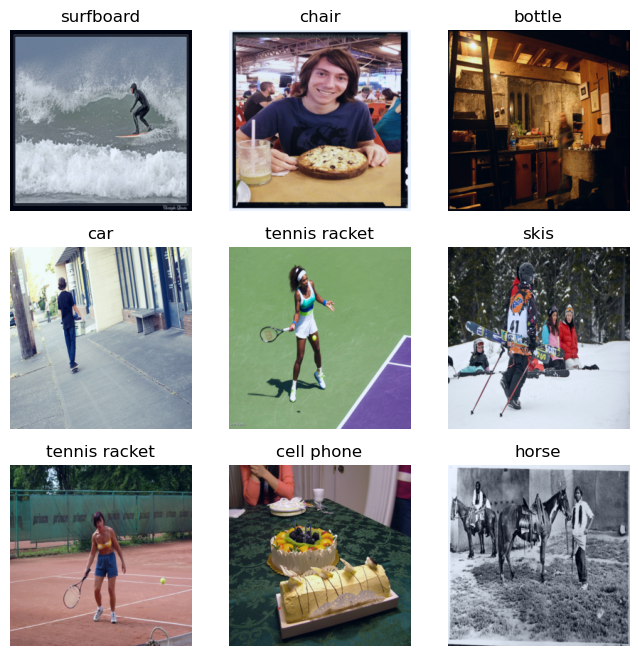

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label, img_id = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(id_target_mapping[label])
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

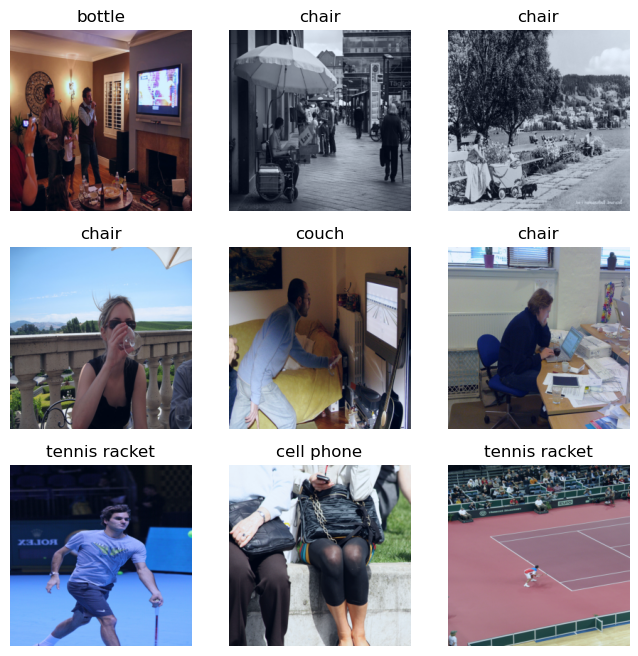

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label, img_id = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(id_target_mapping[label])
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

# Test output of model

In [7]:
os.chdir("../../..//saved_models/mscoco")
print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/saved_models/mscoco


In [8]:
import torch
import torchvision.models as models
import torch.nn as nn

print(os.getcwd())
model = models.resnet50()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # replace the last FC layer
model = model.to(torch.device("cpu"))

state_dict = torch.load("baseline/balanced.pt", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)


/home/gridsan/hzli/CV-Fairness/saved_models/mscoco


<All keys matched successfully>

In [9]:
os.chdir("../../data/datasets/mscoco/")
print(os.getcwd())

/home/gridsan/hzli/CV-Fairness/data/datasets/mscoco


In [10]:
img, label, img_id = test_data[0]
device = torch.device("cpu")
model.eval()
outputs = model(img.unsqueeze(0).to(device))
_, preds = torch.max(outputs, 1)
print("expected: ", id_target_mapping[label], "predicted: ", id_target_mapping[preds.item()])

expected:  tennis racket predicted:  tennis racket


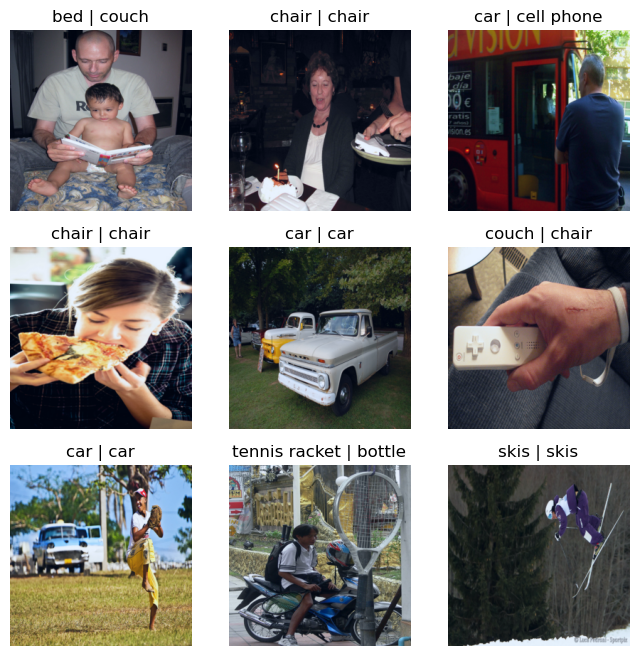

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
model.eval()
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label, img_id = test_data[sample_idx]
    img.to(device)
    outputs = model(img.unsqueeze(0))
    _, preds = torch.max(outputs, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(id_target_mapping[label] + " | " + id_target_mapping[preds.item()])
    plt.axis("off")
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.to(torch.uint8)
    plt.imshow(img.permute(1, 2, 0))
plt.show()